# Setup and imports

In [1]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models

## Load Metadata and Define Classes

In [2]:
import pandas as pd

# Load metadata
metadata = pd.read_csv("data/UrbanSound8K.csv")

# Define SAFE and UNSAFE classes
safe_labels = ['children_playing', 'air_conditioner', 'drilling']
unsafe_labels = ['gun_shot', 'siren', 'dog_bark']

# Filter relevant rows and add binary label
metadata = metadata[metadata['class'].isin(safe_labels + unsafe_labels)].copy()
metadata['binary_label'] = metadata['class'].apply(lambda x: 'safe' if x in safe_labels else 'unsafe')

# Set base path to the audio folders
base_path = "data/"

# Check sample
metadata[['slice_file_name', 'class', 'binary_label', 'fold']].head()


,slice_file_name,class,binary_label,fold
0,100032-3-0-0.wav,dog_bark,unsafe,5
1,100263-2-0-117.wav,children_playing,safe,5
2,100263-2-0-121.wav,children_playing,safe,5
3,100263-2-0-126.wav,children_playing,safe,5
4,100263-2-0-137.wav,children_playing,safe,5


binary_label
safe      3000
unsafe    2303
Name: count, dtype: int64


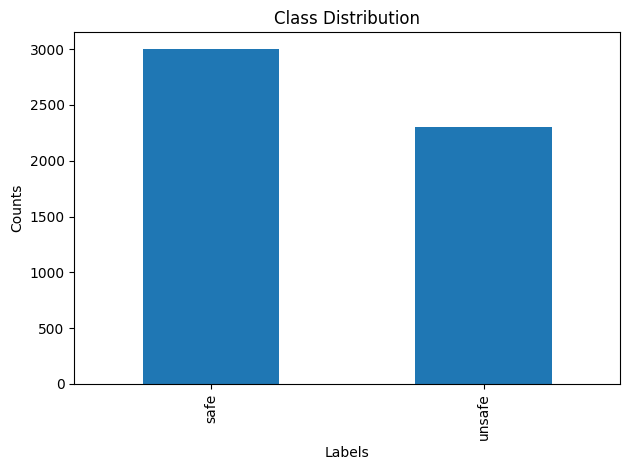

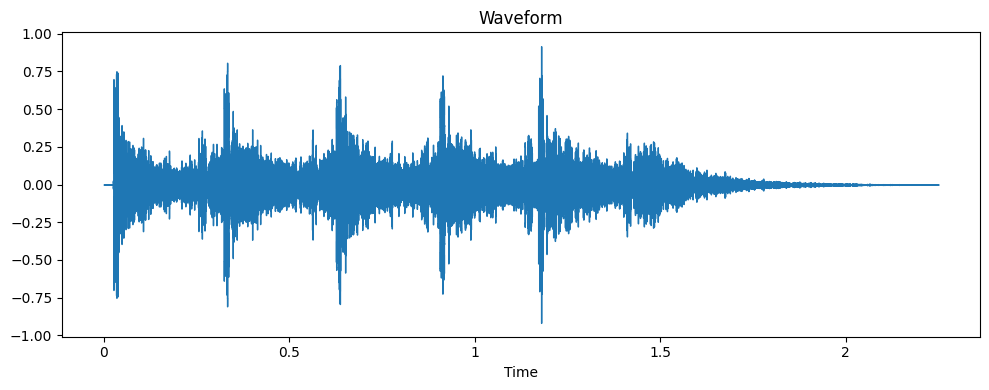

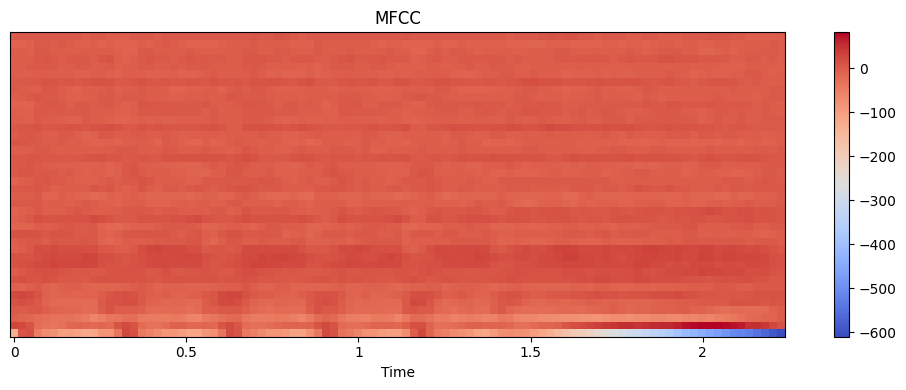

In [3]:
import os
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import librosa.display

# Load metadata
print(metadata['binary_label'].value_counts())

# Plot class distribution
metadata['binary_label'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()

# Plot a sample waveform and spectrogram
sample_path = 'data/fold1/7061-6-0-0.wav'
y, sr = librosa.load(sample_path)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.tight_layout()
plt.show()

mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.show()


In [4]:
import librosa
import numpy as np
import os

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        return mfcc_mean
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


In [5]:
X = []
y = []

for i, row in metadata.iterrows():
    fold = f"fold{row['fold']}"
    file = row['slice_file_name']
    label = row['binary_label']
    path = os.path.join(base_path, fold, file)

    features = extract_features(path)
    if features is not None:
        X.append(features)
        y.append(label)


/Users/negin/anaconda3/envs/safety-audio/lib/python3.9/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels: 'safe' -> 1, 'unsafe' -> 0 (or vice versa)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (4242, 40)
Test shape: (1061, 40)


## Normalizing 

In [7]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both train/test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Training:

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    layers.Input(shape=(40,)),                   # 40 MFCC features
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')        # For binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Show summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.6402 - loss: 0.6156 - val_accuracy: 0.8200 - val_loss: 0.3930
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.8395 - loss: 0.3603 - val_accuracy: 0.8511 - val_loss: 0.3344
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.8708 - loss: 0.3168 - val_accuracy: 0.8794 - val_loss: 0.2929
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - accuracy: 0.9003 - loss: 0.2612 - val_accuracy: 0.8869 - val_loss: 0.2729
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - accuracy: 0.8953 - loss: 0.2580 - val_accuracy: 0.9010 - val_loss: 0.2453
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.9158 - loss: 0.2185 - val_accuracy: 0.9123 - val_loss: 0.2299
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - accuracy: 0.9125 - loss: 0.2185 - val_accuracy: 0.9114 - val_loss: 0.2337
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.9231 - loss: 0.2017 - 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
              precision    recall  f1-score   support

        safe       0.94      0.94      0.94       600
      unsafe       0.93      0.92      0.92       461

    accuracy                           0.93      1061
   macro avg       0.93      0.93      0.93      1061
weighted avg       0.93      0.93      0.93      1061



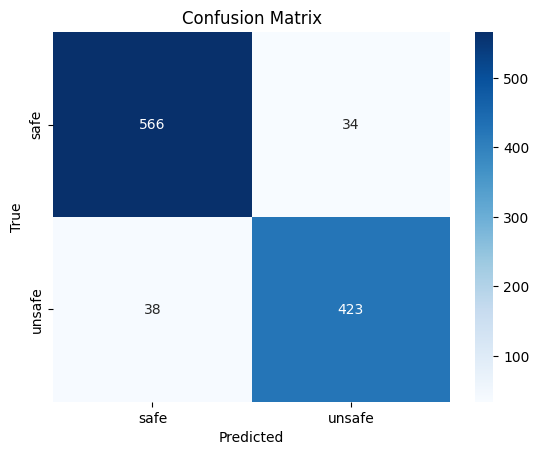

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Print classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
              precision    recall  f1-score   support

        safe       0.95      0.94      0.94       600
      unsafe       0.92      0.93      0.93       461

    accuracy                           0.93      1061
   macro avg       0.93      0.93      0.93      1061
weighted avg       0.94      0.93      0.94      1061



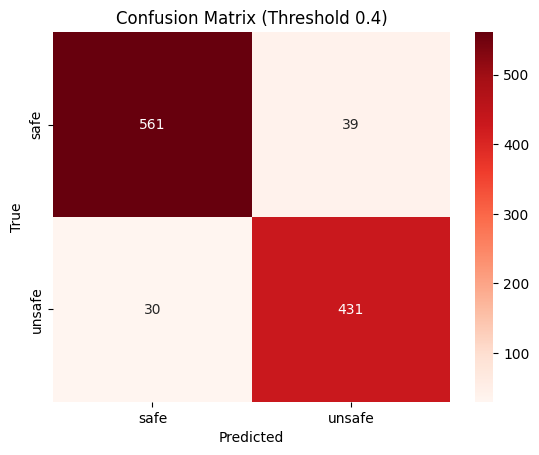

In [11]:
# Predict probabilities
y_pred_prob = model.predict(X_test)

# Apply a lower threshold (e.g., 0.4)
y_pred = (y_pred_prob > 0.4).astype("int32").flatten()

# Evaluate again
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Threshold 0.4)')
plt.show()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


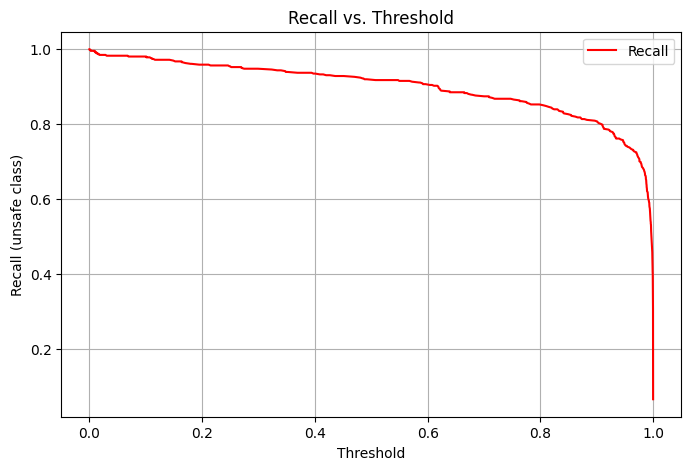

In [12]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_scores = model.predict(X_test)

# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot Recall vs. Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recall[:-1], label='Recall', color='red')
plt.xlabel("Threshold")
plt.ylabel("Recall (unsafe class)")
plt.title("Recall vs. Threshold")
plt.grid(True)
plt.legend()
plt.show()


## Retrain with Class Weight

In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Classes: 0 = safe, 1 = unsafe (or vice versa depending on encoding)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dict for Keras
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)


Class weights: {0: 0.88375, 1: 1.1514657980456027}


In [14]:
# Rebuild the model (optional if you want to reset)
model = models.Sequential([
    layers.Input(shape=(40,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train with class weights
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict
)


Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.6597 - loss: 0.6137 - val_accuracy: 0.7926 - val_loss: 0.4288
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.8282 - loss: 0.3973 - val_accuracy: 0.8473 - val_loss: 0.3579
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.8644 - loss: 0.3306 - val_accuracy: 0.8624 - val_loss: 0.3185
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.8786 - loss: 0.3041 - val_accuracy: 0.8728 - val_loss: 0.2983
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.8962 - loss: 0.2672 - val_accuracy: 0.8831 - val_loss: 0.2743
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.9072 - loss: 0.2376 - val_accuracy: 0.8944 - val_loss: 0.2599
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.9065 - loss: 0.2377 - val_accuracy: 0.8992 - val_loss: 0.2510
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.9217 - loss: 0.2101 - 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
              precision    recall  f1-score   support

        safe       0.95      0.95      0.95       600
      unsafe       0.94      0.94      0.94       461

    accuracy                           0.95      1061
   macro avg       0.95      0.95      0.95      1061
weighted avg       0.95      0.95      0.95      1061



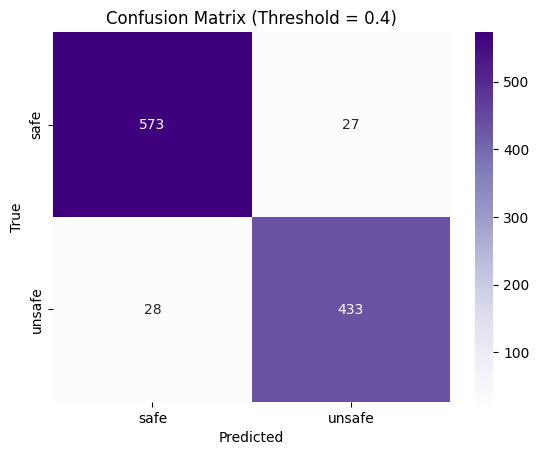

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities on test set
y_pred_prob = model.predict(X_test)

# Apply decision threshold (adjust if needed)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()


In [16]:
model.save("models/safety_classifier_model.h5")

In [17]:
import pickle

with open("models/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

In [18]:
# Save the scaler
with open("models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
